<ipython-input-2-a28dc2f9d6e9>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Epoch 1/10, Loss: 0.0001284802274312824
Epoch 2/10, Loss: 0.00012980833707842976
Epoch 3/10, Loss: 0.000130870146676898
Epoch 4/10, Loss: 0.00013033403956796974
Epoch 5/10, Loss: 0.00012827615137211978
Epoch 6/10, Loss: 0.0001268531195819378
Epoch 7/10, Loss: 0.0001251609792234376
Epoch 8/10, Loss: 0.0001246920000994578
Epoch 9/10, Loss: 0.00012363911082502455
Epoch 10/10, Loss: 0.00012328146840445697


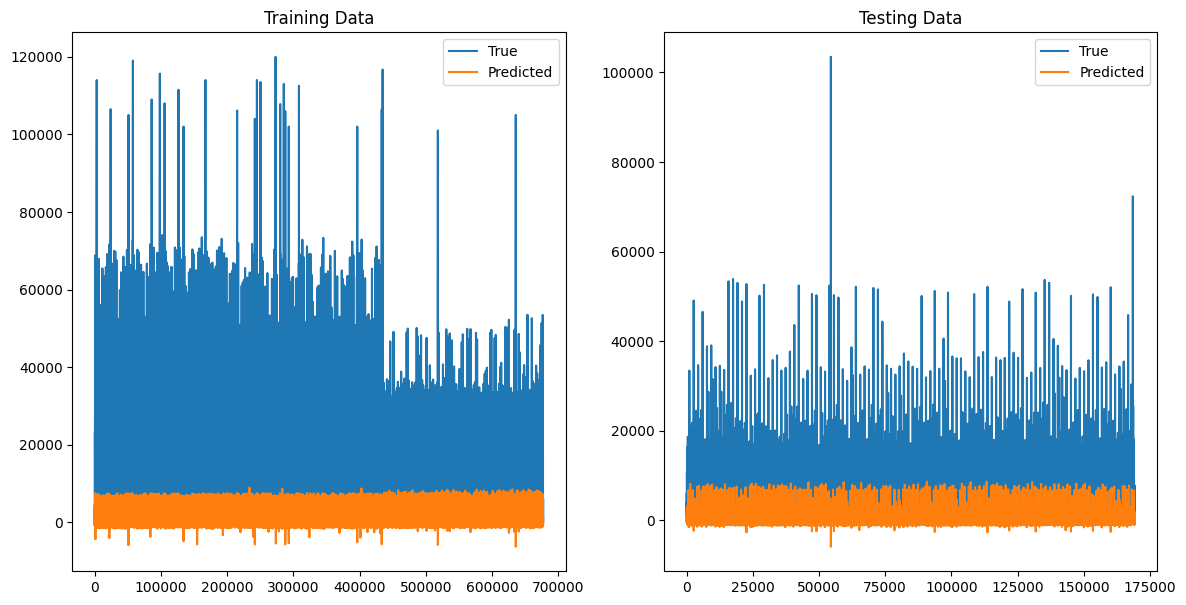

Train MAE: 603.8993530273438, Train MSE: 4123877.75
Test MAE: 565.1152954101562, Test MSE: 2721563.5


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/stock.csv')

# Drop unnecessary columns
df = df[['SYMBOL', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'TIMESTAMP']]

# Fill missing values (if any)
df.fillna(method='ffill', inplace=True)

# Extract features and target variable
features = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].values
target = df['CLOSE'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.reshape(-1, 1))

# Prepare data for LSTM (sequence creation)
def create_sequences(data, target, time_step=5):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(target[i + time_step])
    return np.array(X), np.array(y)

time_step = 5  # Time steps for sequences
X, y = create_sequences(features_scaled, target_scaled, time_step)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# LSTM model definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last hidden state for prediction
        return out

# Hyperparameters
input_size = 4  # Number of features (OPEN, HIGH, LOW, CLOSE)
hidden_size = 64
num_layers = 1
epochs = 10
batch_size = 16  # Reduced batch size
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)

        # Compute the loss
        loss = criterion(outputs, batch_y.view(-1, 1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Evaluate the model
model.eval()
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)

# Rescale predictions and true values
train_preds_rescaled = scaler.inverse_transform(train_preds.detach().numpy())
y_train_rescaled = scaler.inverse_transform(y_train.detach().numpy().reshape(-1, 1))
test_preds_rescaled = scaler.inverse_transform(test_preds.detach().numpy())
y_test_rescaled = scaler.inverse_transform(y_test.detach().numpy().reshape(-1, 1))

# Plot results
plt.figure(figsize=(14, 7))

# Plot training predictions
plt.subplot(1, 2, 1)
plt.plot(y_train_rescaled, label='True')
plt.plot(train_preds_rescaled, label='Predicted')
plt.title('Training Data')
plt.legend()

# Plot testing predictions
plt.subplot(1, 2, 2)
plt.plot(y_test_rescaled, label='True')
plt.plot(test_preds_rescaled, label='Predicted')
plt.title('Testing Data')
plt.legend()

plt.show()

# Evaluate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_train = mean_absolute_error(y_train_rescaled, train_preds_rescaled)
mse_train = mean_squared_error(y_train_rescaled, train_preds_rescaled)
mae_test = mean_absolute_error(y_test_rescaled, test_preds_rescaled)
mse_test = mean_squared_error(y_test_rescaled, test_preds_rescaled)

print(f"Train MAE: {mae_train}, Train MSE: {mse_train}")
print(f"Test MAE: {mae_test}, Test MSE: {mse_test}")
